In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [86]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

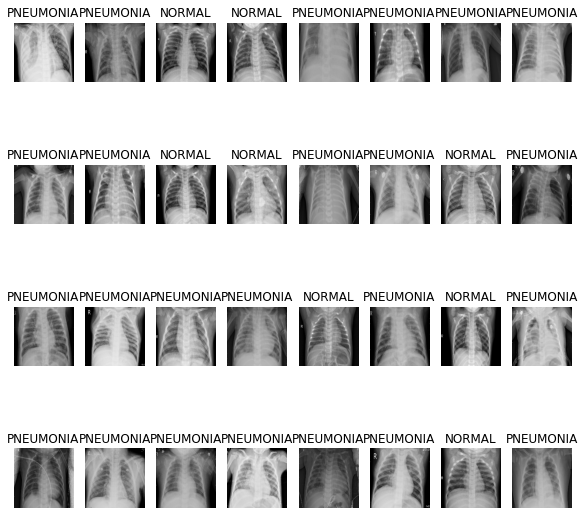

In [87]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [88]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [89]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [90]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 86s 192ms/step - loss: 0.4042 - accuracy: 0.8012 - precision: 0.9512 - recall: 0.7724 - val_loss: 0.5952 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 191ms/step - loss: 0.2419 - accuracy: 0.9045 - precision: 0.9724 - recall: 0.8969 - val_loss: 1.2143 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 191ms/step - loss: 0.2009 - accuracy: 0.9212 - precision: 0.9780 - recall: 0.9147 - val_loss: 0.1774 - val_accuracy: 0.9173 - val_precision: 0.9008 - val_recall: 0.9974
Epoch 4/25
261/261 [==============================] - 50s 193ms/step - loss: 0.1674 - accuracy: 0.9389 - precision: 0.9795 - recall: 0.9375 - val_loss: 0.0809 - val_accuracy: 0.9731 - val_precision: 0.9730 - val_recall: 0.9908
Epoch 5/25
261/261 [==============================] - 51s 197ms/step - loss: 0.1729 - accura

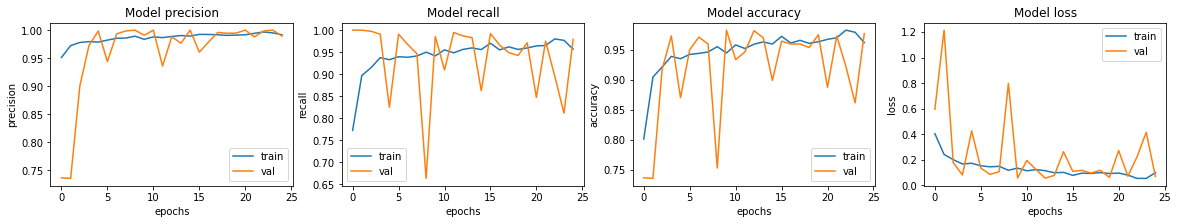

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 0.9905 - accuracy: 0.8029 - precision: 0.7665 - recall: 0.9846
Loss: 0.9904534816741943,
Accuracy: 0.8028846383094788,
Precision: 0.7664670944213867,
Recall: 0.9846153855323792


## 여기부터 실습

## Step 1. 실험환경 Set-up

In [74]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [75]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 5

print(ROOT_PATH)

# 배운대로 초기 epoch는 5정도로 시작해, 나중에 Learning late를 조정하면서 적정 하이퍼 파라미터를 찾은후
# 나중에 다른 하이퍼 파라미터 탐색 후 적정 epoch로 조정할 예정

/aiffel/aiffel


## Step 2. 데이터 준비하기

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [76]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(37)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [77]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1535_virus_2672.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person548_bacteria_2298.jpeg


In [78]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1094
Pneumonia images count in training set: 3091


In [79]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [80]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [81]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [82]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [83]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [84]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [85]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### step 2분기 
**2-1 일단 시키는대로 좌우 반전만 진행**
#### 해보고 싶은 try
2.2 색반전 사진 추가

2.3 크기 확대 사진 추가

In [16]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [17]:
dir(train_ds)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_variable_with_custom_getter',
 '_apply_debug_options',
 '_as_serialized_graph',
 '_buffer_size',
 '_checkpoint_dependencies',
 '_consumers',
 '_deferred_dependencies',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_graph_attr',
 '_handle_deferred_dependencies',
 '_input_dataset',
 '_inputs',
 '_list_extra_dependencies_for_serialization',
 '_list_functions_for_serialization',
 '_lookup_dependency',
 '

In [18]:
print(len(train_ds))

TypeError: dataset length is infinite.

In [19]:
print(len(val_ds))

TypeError: dataset length is infinite.

크기가 정상적으로 늘어났는지 확인하고 싶은데,len도 안되고 info로 받아지지도 않는다.
텐서플로의 데이터셋 다루는 법이 익숙치 않아서 곤란...
이터레이터로 데이터를 하나씩 가져오는 형식인거같긴 한데....

In [1]:
train_list = [i for i in train_ds]
# 매우 비효율적인건 알지만.... 아는건 이방법뿐인데 커널이 나가버린다.. 개수파악은 일단 패스해야겠군

NameError: name 'train_ds' is not defined

## Step 3. 데이터 시각화

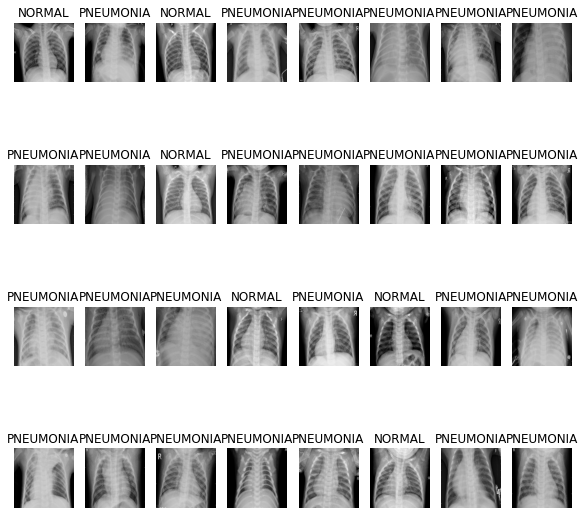

In [16]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

정확한 데이터셋의 개수는 확인할 수 없었지만, 일단 심장의 좌우분포를 보면 좌우반전 사진이 잘 첨부된거 같다.

## Step 4. CNN 모델링

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### step 4 분기
**4-1) 시키는 대로 진행**
#### 해보고 싶은 try
4-2-1) Batch Nomalization만 사용
 - 4-2-2) 활성함수 tanh로 변환
 
4-3) Dropout만 사용

4-4) Conv2D, Maxpool2D 층 한겹 더 쌓아보기   

## Step 5. 데이터 imbalance 처리

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.91
Weight for PNEUMONIA: 0.68


### step 5 분기
**5-1) 시키는 대로 진행**
#### 해보고 싶은 try
5-2) imbalance 과정 생략

5-3) 페렴 사진에 가중치를 더 줘보기

## Step 6. 모델 훈련

In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
130/130 [==============================] - 87s 373ms/step - loss: 0.3929 - accuracy: 0.8089 - precision: 0.9604 - recall: 0.7730 - val_loss: 0.5564 - val_accuracy: 0.7578 - val_precision: 0.7578 - val_recall: 1.0000
Epoch 2/5
130/130 [==============================] - 48s 375ms/step - loss: 0.1969 - accuracy: 0.9274 - precision: 0.9783 - recall: 0.9223 - val_loss: 0.7095 - val_accuracy: 0.7588 - val_precision: 0.7588 - val_recall: 1.0000
Epoch 3/5
130/130 [==============================] - 49s 377ms/step - loss: 0.1685 - accuracy: 0.9409 - precision: 0.9803 - recall: 0.9387 - val_loss: 0.9216 - val_accuracy: 0.7598 - val_precision: 0.7598 - val_recall: 1.0000
Epoch 4/5
130/130 [==============================] - 50s 388ms/step - loss: 0.1448 - accuracy: 0.9502 - precision: 0.9812 - recall: 0.9508 - val_loss: 1.2885 - val_accuracy: 0.7598 - val_precision: 0.7598 - val_recall: 1.0000
Epoch 5/5
130/130 [==============================] - 52s 401ms/step - loss: 0.1384 - accuracy: 0

## Step 7. 결과 확인과 시각화

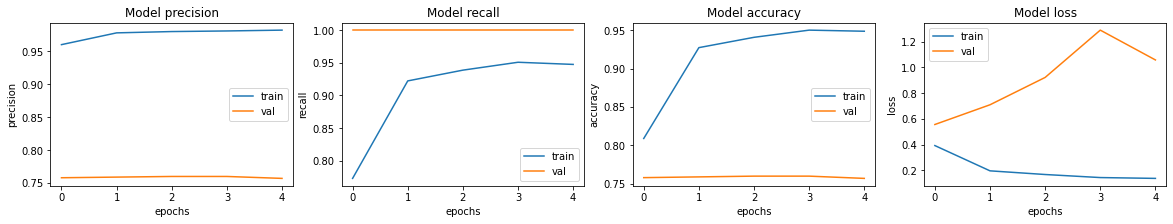

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 233ms/step - loss: 1.9764 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.9764208793640137,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


의도적으로 하이퍼 파라미터를 조정할 계획으로 epoch를 낮게한 것이 문제 였을까?

그래프 상에서는 에포크가 5개가 되기전까지 로스가 증가하다가 감소한것을 보니 Learning rate가 낮게 책정된것을 알 수 있었다.

낮은 Accuracy에도 recall은 지속적으로 높게 유지된것을 보면

모델은 어지간하면 폐렴이라고 답을 내고 있는듯 하다. 일단 에포크를 높여서 다시 확인해보자.

In [25]:
BATCH_SIZE = 32
EPOCHS = 15

In [26]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
130/130 [==============================] - 56s 374ms/step - loss: 0.1319 - accuracy: 0.9517 - precision: 0.9838 - recall: 0.9502 - val_loss: 0.2504 - val_accuracy: 0.8984 - val_precision: 0.8821 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 48s 374ms/step - loss: 0.1375 - accuracy: 0.9493 - precision: 0.9825 - recall: 0.9483 - val_loss: 0.1188 - val_accuracy: 0.9473 - val_precision: 0.9959 - val_recall: 0.9340
Epoch 3/15
130/130 [==============================] - 48s 374ms/step - loss: 0.1179 - accuracy: 0.9570 - precision: 0.9862 - recall: 0.9551 - val_loss: 0.1542 - val_accuracy: 0.9365 - val_precision: 0.9972 - val_recall: 0.9190
Epoch 4/15
130/130 [==============================] - 49s 377ms/step - loss: 0.1049 - accuracy: 0.9620 - precision: 0.9854 - recall: 0.9629 - val_loss: 0.5024 - val_accuracy: 0.8389 - val_precision: 0.9984 - val_recall: 0.7889
Epoch 5/15
130/130 [==============================] - 51s 391ms/step - loss: 0.1045 - accura

In [27]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 195ms/step - loss: 0.4227 - accuracy: 0.8814 - precision: 0.8970 - recall: 0.9154
Loss: 0.4227394163608551,
Accuracy: 0.8814102411270142,
Precision: 0.8969849348068237,
Recall: 0.9153845906257629


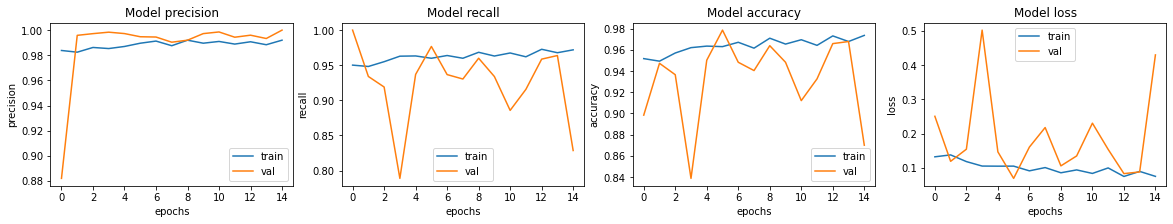

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

실수로 모델을 재정의 하지 않았기는 했는데 그래프의 상태가 정상적이지 않다.
대충 총 epoch 10정도에서 최소 loss값과 최대 accuracy가 나왔고,
종합적인 정확도는 기존보다 오르긴 했지만, 진동하는 그래프가 그려졌다.

아마도 좌우 반전과 양성 음성간 밸런스가 안맞는 것이 batch표본들에 정확하게 분배되지 않으면서
매 epoch마다 loss가 오르거나 내려가는 것으로 예상되므로,
loss가 갑자기 오르는 것은 과적합이라기보다는 batch 표본의 양성/음성 비, 일반/좌우반전 비에 따름이라 판단.
모델이 더 혼란스러워하지 않도록 augmentation은 더 늘리지 말고 epoch는 17로 유지하고자 한다.

In [29]:
BATCH_SIZE = 32
EPOCHS = 17

In [30]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [34]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
    ])
    
    return block
# dropout term 삭제

In [35]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [36]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [37]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/17
130/130 [==============================] - 56s 366ms/step - loss: 0.2067 - accuracy: 0.9185 - precision: 0.9766 - recall: 0.9114 - val_loss: 0.5888 - val_accuracy: 0.7588 - val_precision: 0.7588 - val_recall: 1.0000
Epoch 2/17
130/130 [==============================] - 47s 362ms/step - loss: 0.1399 - accuracy: 0.9483 - precision: 0.9821 - recall: 0.9473 - val_loss: 0.5895 - val_accuracy: 0.7588 - val_precision: 0.7588 - val_recall: 1.0000
Epoch 3/17
130/130 [==============================] - 47s 361ms/step - loss: 0.1082 - accuracy: 0.9608 - precision: 0.9853 - recall: 0.9612 - val_loss: 0.6779 - val_accuracy: 0.7588 - val_precision: 0.7588 - val_recall: 1.0000
Epoch 4/17
130/130 [==============================] - 48s 368ms/step - loss: 0.1081 - accuracy: 0.9603 - precision: 0.9859 - recall: 0.9599 - val_loss: 0.7472 - val_accuracy: 0.7588 - val_precision: 0.7588 - val_recall: 1.0000
Epoch 5/17
130/130 [==============================] - 49s 382ms/step - loss: 0.1086 - accura

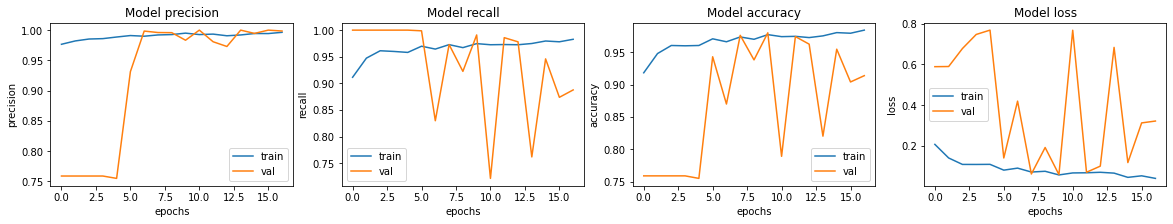

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [39]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 203ms/step - loss: 0.5494 - accuracy: 0.8734 - precision: 0.8659 - recall: 0.9436
Loss: 0.5494465827941895,
Accuracy: 0.8733974099159241,
Precision: 0.8658823370933533,
Recall: 0.9435897469520569


### 4-2-1) drop-out 제거
여전히 진동하는 패턴은 그대로이다.
drop-out 정규화 term을 빼주니까 미세한 감소가 있었고, overfit이 조금더 빨리온거 같기도하다. 둘 다쓰는게 좋은건 사실인걸까

epoch를 조금 내리고 Nomalization을 쓰기전엔 tanh를 활성함수로 써보려고 한다.

In [40]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='tanh', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='tanh', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [41]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='tanh'),
        tf.keras.layers.BatchNormalization(),
    ])
    
    return block
# dropout term 삭제

In [42]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [43]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [44]:
BATCH_SIZE = 32
EPOCHS = 15

In [45]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
130/130 [==============================] - 56s 364ms/step - loss: 0.2584 - accuracy: 0.8724 - precision: 0.9821 - recall: 0.8423 - val_loss: 0.6899 - val_accuracy: 0.7598 - val_precision: 0.7598 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 47s 364ms/step - loss: 0.1376 - accuracy: 0.9474 - precision: 0.9884 - recall: 0.9400 - val_loss: 0.9315 - val_accuracy: 0.7568 - val_precision: 0.7568 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 48s 367ms/step - loss: 0.1183 - accuracy: 0.9553 - precision: 0.9845 - recall: 0.9543 - val_loss: 1.1114 - val_accuracy: 0.7568 - val_precision: 0.7568 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 48s 371ms/step - loss: 0.1077 - accuracy: 0.9647 - precision: 0.9913 - recall: 0.9606 - val_loss: 0.8855 - val_accuracy: 0.7617 - val_precision: 0.7617 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 50s 383ms/step - loss: 0.0915 - accura

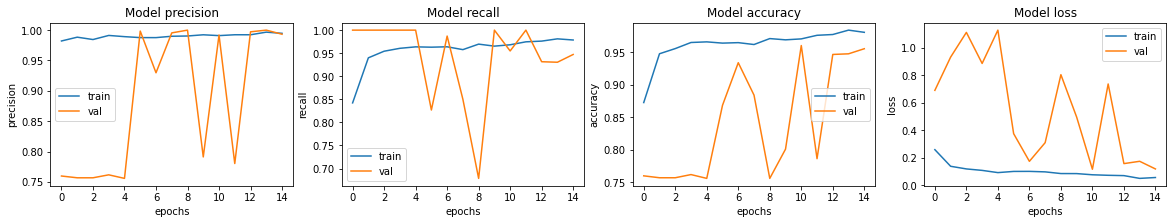

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [47]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 202ms/step - loss: 0.4597 - accuracy: 0.8173 - precision: 0.7887 - recall: 0.9667
Loss: 0.45970773696899414,
Accuracy: 0.817307710647583,
Precision: 0.7887029051780701,
Recall: 0.9666666388511658


### 4-2-2) 활성함수 tanh 사용
혹시나 했는데 loss값은 낮음에도 불구하고 정확도는 많이 떨어지고 대신 recall이 오르는 현상이 나타났다.
val이 굉장히 잘 나와서 내심 기대했는데, 뭔가 아닌가?
tanh보다 ReLU가 더 잘나온다는건 적당히 파라미터들을 드랍하는게 오히려 더 좋은 성능을 나타낸다는 건가 모르겠다.
epoch가 너무 낮아서 과적합이 되는 타이밍을 정확하게 못찾는게 아닐까 싶어 혹시나하는 마음에 한번만 더 이어서 해보고자한다.
이론상 tanh가 성능이 더 잘나올꺼같은데...

In [48]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
130/130 [==============================] - 54s 366ms/step - loss: 0.0699 - accuracy: 0.9760 - precision: 0.9940 - recall: 0.9733 - val_loss: 0.1511 - val_accuracy: 0.9463 - val_precision: 0.9945 - val_recall: 0.9345
Epoch 2/15
130/130 [==============================] - 47s 362ms/step - loss: 0.0491 - accuracy: 0.9834 - precision: 0.9950 - recall: 0.9824 - val_loss: 0.1049 - val_accuracy: 0.9609 - val_precision: 0.9959 - val_recall: 0.9521
Epoch 3/15
130/130 [==============================] - 48s 368ms/step - loss: 0.0641 - accuracy: 0.9760 - precision: 0.9927 - recall: 0.9747 - val_loss: 0.1325 - val_accuracy: 0.9414 - val_precision: 0.9293 - val_recall: 0.9987
Epoch 4/15
130/130 [==============================] - 48s 374ms/step - loss: 0.0526 - accuracy: 0.9796 - precision: 0.9960 - recall: 0.9762 - val_loss: 0.2280 - val_accuracy: 0.8828 - val_precision: 0.8659 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 50s 387ms/step - loss: 0.0490 - accura

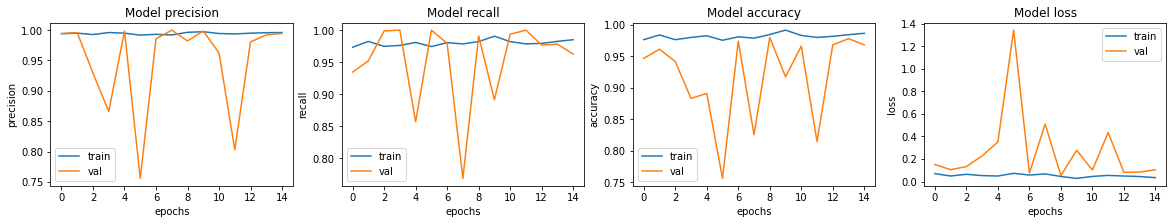

In [49]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [50]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 214ms/step - loss: 0.5676 - accuracy: 0.8077 - precision: 0.7885 - recall: 0.9462
Loss: 0.5675719380378723,
Accuracy: 0.807692289352417,
Precision: 0.7884615659713745,
Recall: 0.9461538195610046


여전히 별로다. 여전히 리콜만 높은 모델이 만들어졌음을 알 수 있다. epoch가 많이 늘어나면 저 진동이 사라질꺼라고 예상했지만 전혀 그렇지 않았다는점도 생각해볼 문제인거 같다. 이유는 모르겠지만, tanh를 쓰면 recall이 유의미하게 증가하는것도 확인했다.

In [52]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [53]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [54]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [55]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [56]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
130/130 [==============================] - 56s 368ms/step - loss: 0.6933 - accuracy: 0.5240 - precision: 0.7364 - recall: 0.5543 - val_loss: 0.7071 - val_accuracy: 0.2441 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
130/130 [==============================] - 47s 363ms/step - loss: 0.6948 - accuracy: 0.5060 - precision: 0.7352 - recall: 0.5153 - val_loss: 0.7001 - val_accuracy: 0.2432 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
130/130 [==============================] - 47s 362ms/step - loss: 0.6932 - accuracy: 0.5255 - precision: 0.7304 - recall: 0.5675 - val_loss: 0.7029 - val_accuracy: 0.2451 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/15
130/130 [==============================] - 48s 371ms/step - loss: 0.6929 - accuracy: 0.4139 - precision: 0.7165 - recall: 0.3441 - val_loss: 0.6965 - val_accuracy: 0.2432 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/15
130/130 [==============================] - 50s 38

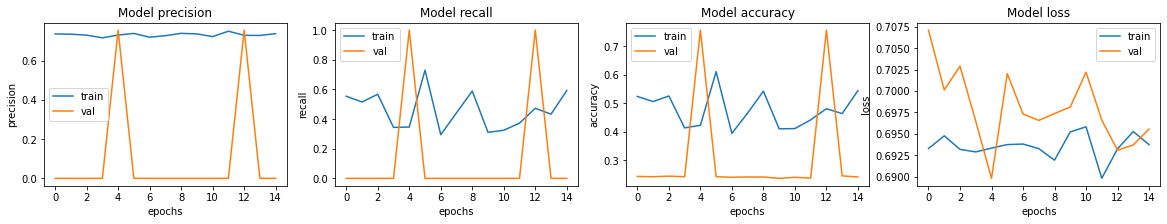

In [57]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [58]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 207ms/step - loss: 0.6943 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss: 0.6943221688270569,
Accuracy: 0.375,
Precision: 0.0,
Recall: 0.0


### 4-3) BatchNormalization 제거
난리가 났다. 모델 깊이가 꽤 깊다보니 Normalization없이는 그래디언트가 수렴하거나 발산해버려서 학습이 일어나기도 전에 터져버렸다.

4-4)는 기각하고 가장 무난한 결과를 보였던 4-1)을 그대로 사용해야겠다.


In [59]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [60]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [61]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [65]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)*3/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.91
Weight for PNEUMONIA: 2.03


In [66]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [67]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
130/130 [==============================] - 57s 372ms/step - loss: 0.7954 - accuracy: 0.8392 - precision: 0.9392 - recall: 0.8360 - val_loss: 0.6517 - val_accuracy: 0.7607 - val_precision: 0.7607 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 48s 369ms/step - loss: 0.3892 - accuracy: 0.9334 - precision: 0.9573 - recall: 0.9526 - val_loss: 0.8523 - val_accuracy: 0.7588 - val_precision: 0.7588 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 48s 368ms/step - loss: 0.3515 - accuracy: 0.9413 - precision: 0.9578 - recall: 0.9628 - val_loss: 0.9421 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 48s 371ms/step - loss: 0.2996 - accuracy: 0.9486 - precision: 0.9634 - recall: 0.9672 - val_loss: 1.1459 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 50s 386ms/step - loss: 0.2399 - accura

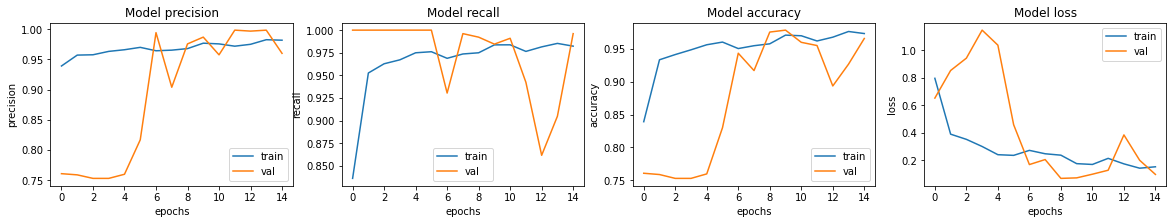

In [68]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [69]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 200ms/step - loss: 1.2843 - accuracy: 0.7067 - precision: 0.6806 - recall: 1.0000
Loss: 1.2842735052108765,
Accuracy: 0.7067307829856873,
Precision: 0.6806282997131348,
Recall: 1.0


### 5-2) imbalance 과정 생략
확실히 가중치를 없애니 성능은 많이 떨어졌지만 위아래로 진동하던 문제는 조금 해결된 것처럼 보인다.
여전히 전혀 없는건 아니긴하지만, 통제가 안되는 변수인 반전사진을 넣는것은 아무래도 그다지 좋은 선택이 아니었나 싶기도 하다.
넣을꺼면 배치에 반전사진과 일반사진의 비율정도는 통일시켜줘야하지 않을까 싶다.

5-3)은 해보지 않아도 충분할듯 싶다. 양성사진에 가중치를 올려줌으로써 
정밀도를 희생해 recall을 어느정도 올릴 수 있다는건 확실히 알꺼같다.

### 마지막으로 가설 검증 : 과연 반전사진과 가중치를 쓰지않으면 진동은 사라질까?

In [70]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [91]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [92]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
130/130 [==============================] - 57s 369ms/step - loss: 0.8066 - accuracy: 0.8334 - precision: 0.9414 - recall: 0.8259 - val_loss: 0.6290 - val_accuracy: 0.7578 - val_precision: 0.7578 - val_recall: 1.0000
Epoch 2/5
130/130 [==============================] - 46s 359ms/step - loss: 0.3775 - accuracy: 0.9399 - precision: 0.9608 - recall: 0.9577 - val_loss: 0.7703 - val_accuracy: 0.7617 - val_precision: 0.7617 - val_recall: 1.0000
Epoch 3/5
130/130 [==============================] - 47s 365ms/step - loss: 0.2981 - accuracy: 0.9510 - precision: 0.9671 - recall: 0.9664 - val_loss: 1.0408 - val_accuracy: 0.7539 - val_precision: 0.7539 - val_recall: 1.0000
Epoch 4/5
130/130 [==============================] - 49s 376ms/step - loss: 0.3065 - accuracy: 0.9452 - precision: 0.9597 - recall: 0.9665 - val_loss: 1.4396 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 5/5
130/130 [==============================] - 50s 386ms/step - loss: 0.2245 - accuracy: 0

In [93]:
BATCH_SIZE = 32
EPOCHS = 15

In [94]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
130/130 [==============================] - 55s 367ms/step - loss: 0.2048 - accuracy: 0.9627 - precision: 0.9709 - recall: 0.9788 - val_loss: 0.4146 - val_accuracy: 0.8516 - val_precision: 0.8364 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 47s 362ms/step - loss: 0.2169 - accuracy: 0.9635 - precision: 0.9710 - recall: 0.9798 - val_loss: 0.1141 - val_accuracy: 0.9609 - val_precision: 0.9946 - val_recall: 0.9536
Epoch 3/15
130/130 [==============================] - 46s 359ms/step - loss: 0.1653 - accuracy: 0.9702 - precision: 0.9746 - recall: 0.9854 - val_loss: 0.1930 - val_accuracy: 0.9336 - val_precision: 0.9972 - val_recall: 0.9148
Epoch 4/15
130/130 [==============================] - 46s 356ms/step - loss: 0.1785 - accuracy: 0.9671 - precision: 0.9751 - recall: 0.9805 - val_loss: 0.1160 - val_accuracy: 0.9600 - val_precision: 0.9986 - val_recall: 0.9484
Epoch 5/15
130/130 [==============================] - 49s 378ms/step - loss: 0.1727 - accura

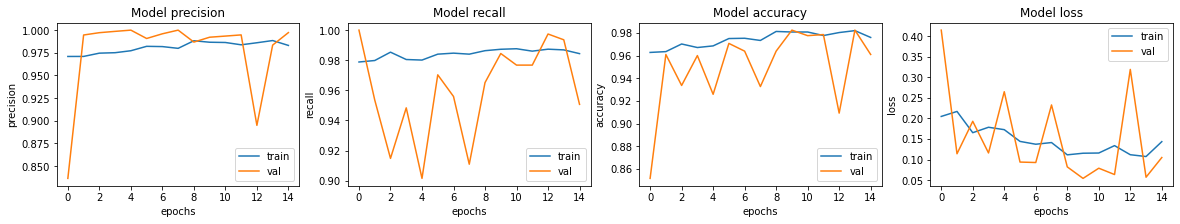

In [95]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [96]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 208ms/step - loss: 0.7462 - accuracy: 0.8333 - precision: 0.7967 - recall: 0.9846
Loss: 0.7461789846420288,
Accuracy: 0.8333333134651184,
Precision: 0.7966805100440979,
Recall: 0.9846153855323792


다른때에 비해서 진폭이 그렇게 크지 않았지만, 여전히 진폭이 존재하는 모습을 볼 수 있다. 아마 배경이나 크기등의 변수들이 정확하게 통제되지 않은 영향이거나 가설이 틀렸을 가능성도 부정할 수 없다. 

가중치를 (거의) 평준화해줬기 때문에 여전히 낮은 accuracy 대비 높은 recall율을 보이며, 결과적으로 좌우반전 사진을 추가한 것은
정확도 상승과 큰 관계가 없음도 확인 할 수 있었다.

결론적으로 가장 좋은 점수를 낸 것은 초기 모델 그대로였고,
예상과는 다르게 Batch Nomalization에서 ReLU함수를 쓰는 것이 tanh를 쓰는것보다 좋음도 확인했다.(버릴 노드 빨리 버리는게 이득)

개인적인 생각으로는 사진에서 필요한 폐렴관련 정보는 미세한 흰색 구름모양을 확인하면 되는것이고
그것 대비 모델은 너무 Deep하고, 해상도가 너무 작은 문제가 정확한 판단을 어렵게 하는게 아닌가 싶다.

그림의 크기가 더 크고 대신 필터의 크기도 늘리면서, MaxPooling도 늘려 파라미터가 너무 많아지지 않도록 하는 것이 좋아보인다.

양성 음성 데이터의 경우도 과도하게 가중치를 부여해 1:1 비율을 맞추기보다는 Recall을 적당히 늘리는 정도로만 가중치를 부여해 정확도가 너무 떨어지지 않으면서도 recall이 높은 모델을 만들 수 있을 것으로 보인다.